In [28]:
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline

In [29]:
t_original=time.time()

In [30]:
df_train=pd.read_csv('train.csv')
df_songs=pd.read_csv('songs.csv')
df_test=pd.read_csv('test.csv')

In [ ]:
song_source=df_train.drop_duplicates(['song_id','source_system_tab']).groupby('song_id')['target'].agg(len)

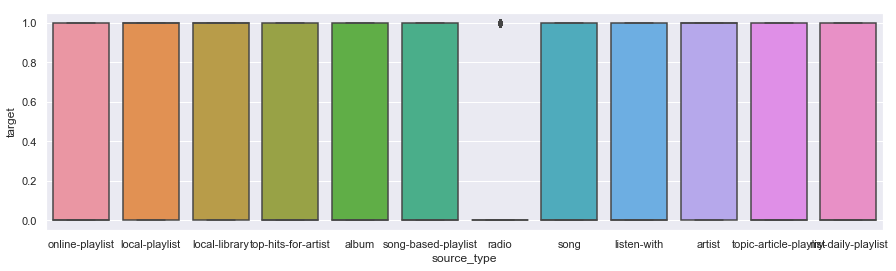

In [110]:
sns.set(rc={'figure.figsize':(15,4)})
ax = sns.boxplot(x="source_type", y="target", data=df_train)

In [111]:
print('# of songs',len(df_train['song_id'].unique().tolist()))
print('# of users',len(df_train['msno'].unique().tolist()))

# of songs 359966
# of users 30755


In [112]:
# number of songs, listend, rate is null
len(df_train[df_train['target'].isnull()])

0

In [113]:
df_test['user_exist']=0
df_test.loc[df_test['msno'].isin(df_train['msno']),'user_exist']=1
df_test['song_exist']=0
df_test.loc[df_test['song_id'].isin(df_train['song_id']),'song_exist']=1

print('# of new songs',len(df_test[~df_test['song_id'].isin(df_train['song_id'])]['song_id'].unique().tolist()))
print('# of songs',len(df_test['song_id'].unique().tolist()))
print('# of new users',len(df_test[~df_test['msno'].isin(df_train['msno'])]['msno'].unique().tolist()))
print('# of users',len(df_test['msno'].unique().tolist()))

# of new songs 59873
# of songs 224753
# of new users 3648
# of users 25131


In [114]:
# all songs
print(len(df_songs))
# songs in the test set
df_songs_selected=df_songs[df_songs['song_id'].isin(df_test['song_id'].tolist())]
print(len(df_songs_selected))
# songs in the test set, not listened
df_songs_selected_notlistened=df_songs_selected[~df_songs_selected['song_id'].isin(df_train['song_id'].tolist())]
print(len(df_songs_selected_notlistened))

2296320
224739
59867


# 1 content based recommender

In [115]:
import time
def preprocess(df_songs):
    t=time.time()
    print('preprocess df_songs')
    def split_genre(x):
        x=str(x).split('|')
        return x*2
    df_songs['genre_ids_new']=df_songs['genre_ids'].apply(split_genre)

    def split_artist(x):
        try:
            x=x.split('|')
            x=[i.replace(' ','') for i in x]
            return x
        except:
            return []
    df_songs['artist_name_new']=df_songs['artist_name'].apply(split_artist)
    df_songs['composer_new']=df_songs['composer'].apply(split_artist)
    df_songs['lyricist_new']=df_songs['lyricist'].apply(split_artist)

    def cal_language(x):
        try:
            return ['lan_'+str(int(x))]
        except:
            return []
    df_songs['language_new']=df_songs['language'].apply(cal_language)

    def add_vas(row,cols):
        out=[]
        for col in cols:
            out+=row[col]
        return ' '.join(out)
    cols=['language_new','artist_name_new','composer_new','lyricist_new','genre_ids_new']
    df_songs['vars']=df_songs.apply(lambda x: add_vas(x,cols),axis=1)
    
    print('add new column')
    max_,min_=df_songs['song_length'].max(),df_songs['song_length'].min()
    df_songs['song_length_new']=df_songs['song_length'].apply(lambda x: (x-min_)/(max_-min_))
    new_column=np.reshape(df_songs['song_length_new'].values,(-1,1))
    
    from sklearn.feature_extraction.text import CountVectorizer
    ct = CountVectorizer(analyzer='word',min_df=0)
    tfidf_matrix = ct.fit_transform(df_songs['vars'])
    
    import scipy as sp
    tfidf_matrix_new = sp.sparse.hstack((tfidf_matrix, new_column))
    
    print('time used',time.time()-t)
    return tfidf_matrix_new.tocsr()

In [116]:
def find_similar_songs(tfidf_matrix,df_songs_new,df_songs_old):
    from sklearn.metrics.pairwise import cosine_similarity # create distance metric
    song_id_old=list(df_songs_old.index)
    song_id_new=list(df_songs_new.index)
    song_dict={}
    
    chunk_size=1000
    for i in range(len(song_id_new)//chunk_size+1):
        song_id_new_chunks=song_id_new[i*chunk_size:(i+1)*chunk_size]
        scores=cosine_similarity(tfidf_matrix[song_id_new_chunks],tfidf_matrix[song_id_old])
        for i_score in range(len(scores)):
            song_dict[df_songs_new.iloc[i*chunk_size+i_score]['song_id']]=df_songs_old.iloc[np.argmax(scores[i_score])]['song_id']
        print('processing chunk',i)
    return song_dict

In [117]:
tfidf_matrix=preprocess(df_songs)

preprocess df_songs
add new column
time used 315.2683250904083


In [118]:
import scipy as sp
sp.sparse.save_npz("tfidf_matrix.npz", tfidf_matrix)

In [8]:
import scipy as sp
tfidf_matrix= sp.sparse.load_npz("tfidf_matrix.npz")

In [119]:
print('step 1: find most similar song for new song')
df_songs_old=df_songs[(df_songs['song_id'].isin(df_test['song_id'].tolist()))& (df_songs['song_id'].isin(df_train['song_id'].tolist()))]
df_songs_new=df_songs[df_songs['song_id'].isin(df_test['song_id'].tolist())& (~df_songs['song_id'].isin(df_train['song_id'].tolist()))]
del df_songs

step 1: find most similar song for new song


In [120]:
import time
t=time.time()
song_dict=find_similar_songs(tfidf_matrix,df_songs_new,df_songs_old)
print('time used',time.time()-t)

processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
processing chunk 9
processing chunk 10
processing chunk 11
processing chunk 12
processing chunk 13
processing chunk 14
processing chunk 15
processing chunk 16
processing chunk 17
processing chunk 18
processing chunk 19
processing chunk 20
processing chunk 21
processing chunk 22
processing chunk 23
processing chunk 24
processing chunk 25
processing chunk 26
processing chunk 27
processing chunk 28
processing chunk 29
processing chunk 30
processing chunk 31
processing chunk 32
processing chunk 33
processing chunk 34
processing chunk 35
processing chunk 36
processing chunk 37
processing chunk 38
processing chunk 39
processing chunk 40
processing chunk 41
processing chunk 42
processing chunk 43
processing chunk 44
processing chunk 45
processing chunk 46
processing chunk 47
processing chunk 48
processing chunk 49
processing

In [121]:
# validation purpose
print(len(song_dict.keys()))
print(len(df_songs_new))

59867
59867


In [122]:
del df_songs_old,df_songs_new,tfidf_matrix

In [123]:
df_test['song_id']=df_test['song_id'].apply(lambda x: song_dict.get(x,x))

In [131]:
# songs not in the song database or user database
df_test['song_exist']=1
df_test.loc[(~df_test['song_id'].isin(df_songs['song_id'])) & (~df_test['song_id'].isin(df_train['song_id'])),'song_exist']=0
print('# of songs not in all database, but only in test',len(df_test[df_test['song_exist']==0]))
del df_songs

# of songs not in all database, but only in test 9


# 2 collaborate filtering svd method

In [31]:
#%% collaborative filtering
from surprise import Reader, Dataset, SVD, KNNBasic, evaluate,accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
import time

In [6]:
# tune parameter via a sub-set of the entire dataset
import random
sampled_id=random.sample(set(df_train['msno']), 2000)
# read in data
reader = Reader(rating_scale=(0,1))
sampled_df=df_train[df_train['msno'].isin(sampled_id)][['msno', 'song_id', 'target']]
print(len(sampled_df),'%',len(sampled_df)/len(df_train)*100)
data = Dataset.load_from_df(sampled_df, reader)

484807 % 6.5714996764450655


# step 1: split training (90%) and testing (10%); 

In [18]:
data = Dataset.load_from_df(sampled_df, reader)
raw_ratings = data.raw_ratings

# shuffle ratings 
random.shuffle(raw_ratings)

# build training(90%) and testing (10%)
# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
training_ratings = raw_ratings[:threshold]
testing_ratings = raw_ratings[threshold:]

# step 2: cross validation

In [21]:
# training set, cross-validation to tune parameters
data.raw_ratings = training_ratings  

# grid search to find best score plus cross-validation
print('Grid Search...')
import time
t=time.time()
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors':[10],'n_epochs': [5, 10], 'lr_all': [0.002], 'reg_all': [0.4],'verbose':[True]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

results_df_svd = pd.DataFrame.from_dict(gs.cv_results)
#print(results_df_svd)

# use the best estimator as the final model
model_final_svd = gs.best_estimator['rmse']
print('time used',time.time()-t)

Grid Search...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
0.46421888681858975
{'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4, 'verbose': True}
time used 34.7675576210022

In [26]:
# retrain on the training set 
trainset = data.build_full_trainset()
model_final_svd.fit(trainset)

# Compute biased accuracy on training
predictions = model_final_svd.test(trainset.build_testset())
print('Biased accuracy on training set,', end='   ')
accuracy.rmse(predictions)

# Compute unbiased accuracy on testing
testset = data.construct_testset(testing_ratings)  # testset is now the set B
predictions = model_final_svd.test(testset)
print('Unbiased accuracy on testing set,', end=' ')
accuracy.rmse(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Biased accuracy on training set,   RMSE: 0.4560
Unbiased accuracy on testing set, RMSE: 0.4623


0.46232162164106316

In [134]:
# grid search to find best score plus cross-validation
import time
t=time.time()
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors':[10,20,50],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6],'verbose':[True]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

results_df_svd = pd.DataFrame.from_dict(gs.cv_results)
print(results_df_svd)

# use the best estimator as the final model
model_final_svd = gs.best_estimator['rmse']
print('time used',time.time()-t)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing e

Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing e

In [32]:
# if already tuned parameters
model_final_svd=SVD(n_factors=10,n_epochs=10,lr_all=0.005,reg_all=0.4,verbose=True)

In [33]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(df_train[['msno', 'song_id', 'target']], reader)
# fit using the best parameter
trainset=data.build_full_trainset()
model = model_final_svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


# step 3: rate existing users

In [137]:
print('step 2: rate existing users')
for ind, row in df_test[df_test['user_exist']==1].iterrows():
    score=model.predict(row['msno'],row['song_id']).est
    df_test.set_value(ind,'target',score)

step 2: rate existing users


# recommend top n

In [34]:
#Return the top-N recommendation for each user from a set of predictions.
def get_top_n(predictions, n=10):
    from collections import defaultdict
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [35]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [ ]:
# this takes a really long time
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

print('get top n')
top_n = get_top_n(predictions[:5], 3)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

print('get precision/recall')
# precision & recall per user
prec,rec=precision_recall_at_k(predictions, k=3, threshold=0.8)
print(prec,rec)

# 3 new users -> similarity of users based on demographic data

In [139]:
df_members=pd.read_csv('members.csv')

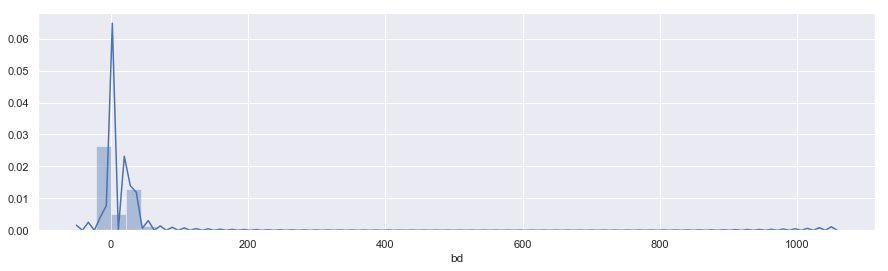

In [140]:
sns.distplot(df_members['bd'],bins=50)

In [ ]:
df_members=pd.concat([df_members,pd.get_dummies(df_members['gender'])],axis=1).drop('gender',axis=1)
df_members=pd.concat([df_members,pd.get_dummies(df_members['registered_via'])],axis=1).drop('registered_via',axis=1)
df_members=pd.concat([df_members,pd.get_dummies(df_members['city'])],axis=1).drop('city',axis=1)

def qaqc_bd(x):
    if x<=5 or x>150:
        x=np.NAN
    return x
mean_val=df_members['bd'].mean()
df_members['bd']=df_members['bd'].apply(qaqc_bd).fillna(mean_val)

In [143]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
data=df_members[[x for x in df_members.columns.values.tolist() if x!='msno']]

scaler.fit(data)
data=scaler.transform(data)
 
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(data)

df_members['group']=list(kmeans.predict(data))

df_members['user_exist']=0
df_members.loc[df_members['msno'].isin(df_train['msno']),'user_exist']=1
print(df_members[df_members['user_exist']==1]['group'].value_counts())

member_dict={}
for ind,row in df_members.iterrows():
    member_dict[row['msno']]=row['group']

3    9898
0    8835
4    8475
2    3257
1     290
Name: group, dtype: int64


In [144]:
# temporarily ouput the file
df_member_gp=pd.DataFrame.from_dict(member_dict,orient='index').rename(columns={0:'group'})
df_member_gp['msno']=df_member_gp.index
df_member_gp.to_csv('member_dict.csv',index=False)

In [145]:
# if wanna read the file
df_member_gp=pd.read_csv('member_dict.csv')
member_dict={}
for ind, row in df_member_gp.iterrows():
    member_dict[row['msno']]=row['group']

In [146]:
del data,df_members

In [147]:
df_test['group']=df_test['msno'].apply(lambda x: member_dict.get(x))
df_train['group']=df_train['msno'].apply(lambda x: member_dict.get(x))

In [148]:
print('step 3.1: # of null values',len(df_test[df_test['target'].isnull()]))
print('for that song, use median value of the user group')
medians_gp=df_train[df_train['song_id'].isin(df_test[df_test['user_exist']==0]['song_id'])]\
.groupby(['song_id','group'],as_index=False)['target'].agg(np.median).rename(columns={'target':'target_median_gp'})
df_test=df_test.merge(medians_gp[['target_median_gp','song_id','group']],how='left',on=['song_id','group'])
df_test.loc[df_test['user_exist']==0,'target']=df_test.loc[df_test['user_exist']==0,'target_median_gp']
df_test.drop('target_median_gp',axis=1,inplace=True)

print('step 3.2: # of null values',len(df_test[df_test['target'].isnull()]))
print('for that song, use median value of the entire user database')
if len(df_test[df_test['target'].isnull()])>0:
    medians=df_train[df_train['song_id'].isin(df_test[df_test['target'].isnull()]['song_id'])]\
    .groupby('song_id',as_index=False)['target'].agg(np.median).rename(columns={'target':'target_median'})
    df_test=df_test.merge(medians[['target_median','song_id']],how='left',on='song_id')
    df_test.loc[df_test['target'].isnull(),'target']=df_test.loc[df_test['target'].isnull(),'target_median']
    df_test.drop('target_median',inplace=True,axis=1)

print('step 3.3: # of null values',len(df_test[df_test['target'].isnull()]))
print('regardless of song, use the median of the entire user group')
if len(df_test[df_test['target'].isnull()])>0:
    medians=df_train[df_train['group'].isin(df_test[df_test['target'].isnull()]['group'])]\
    .groupby('group',as_index=False)['target'].agg(np.median).rename(columns={'target':'target_median'})
    medians_dict={}
    for ind, row in medians.iterrows():
        medians_dict[row['group']]=row['target_median']
    df_test.loc[df_test['target'].isnull(),'target']=df_test.loc[df_test['target'].isnull(),'group']\
                                                                         .apply(lambda x: medians_dict.get(x))
    del medians_dict
print('finally # of null values',len(df_test[df_test['target'].isnull()]))

step 3.1: # of null values 184018
for that song, use median value of the user group
step 3.2: # of null values 11697
for that song, use median value of the entire user database
step 3.3: # of null values 3
regardless of song, use the median of the entire user group
finally # of null values 0


In [149]:
df_test[['target','id']].to_csv('results.csv',index=False)
print('total time used',t-t_original)

total time used 1049.6866645812988


# others

In [ ]:
# read in data
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(df_train[['msno', 'song_id', 'target']], reader)

In [ ]:
from surprise import Reader, Dataset, SVD, KNNBasic, evaluate,accuracy
import time
data.split(n_folds=3)
t=time.time()
model_svd=SVD()
evaluate(model_svd, data, measures=['RMSE', 'MAE'])
print('time used',time.time()-t)

In [ ]:
def rate_basedon_history(tfidf_matrix,new_song_id,df_songs_selected,df_train_selected):
    from sklearn.metrics.pairwise import cosine_similarity # create distance metric
    user_song_id=list(df_songs_selected.index)
    scores=cosine_similarity(tfidf_matrix[[new_song_id]],tfidf_matrix[user_song_id])
    df_songs_selected['score']=list(scores[0])
    df_songs_selected=df_songs_selected.merge(df_train_selected,on='song_id')
    if len(df_songs_selected)>=5:
        results=df_songs_selected.sort_values('score',ascending=0).head(5)
        return np.median(results['target'])
    else:
        return np.median(df_songs_selected['target'])